## Quantifiziertes Selbst: Aktivitätstracker Datenanalyse (Garmin) (2013-2019)
![title](activities.png)

In [1]:
# Importieren der erforderlichen Libs (Python + R-Interoperabilität)
import pandas as pd
import math
import warnings
import numpy as np

# Windows hack
import os
os.environ["R_HOME"] = r"C:\Program Files\R\R-4.0.2"
os.environ["PATH"]   = r"C:\Program Files\R\R-4.0.2\bin\x64" + ";" + os.environ["PATH"]

from rpy2.robjects import pandas2ri
pandas2ri.activate()
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (20,20)
%reload_ext rpy2.ipython
%matplotlib inline
pd.options.display.max_rows = 999
sns.set_style("white")

In [2]:
# Aktivitätsdaten werden als csv-Datei von Garmin Connect (https://connect.garmin.com/) heruntergeladen.
path = "GarminActivitiesDataset_Axenie"

# new dataframe to hold the data
frame = pd.DataFrame()
list_ = []

# assemble the path
file_path = path + ".csv"
df = pd.read_csv(file_path, index_col=None, header=0)
list_.append(df)
frame = pd.concat(list_)

# drop unnecessary cols    
frame.reset_index(inplace=True)
frame.drop("index", axis=1, inplace=True)

# rename columns for readability
col_names = ['activityType', 'startTime', 'actDistance',  'calories', 'activityTime', 'avgHR', 'maxHR', 'avgSpeed', 'elevationGain']
frame.columns = col_names

In [3]:
# Korrigieren von Datenfehlern und Datentypen
# Nan policy and data types conversion
frame["avgHR"] = frame["avgHR"].replace(['--'], np.NaN)
frame["maxHR"] = frame["maxHR"].replace(['--'], np.NaN)
frame['avgHR'] = frame.avgHR.astype(float)
frame['maxHR'] = frame.maxHR.astype(float)
frame["elevationGain"] = frame["elevationGain"].replace(['--', '0', 0], np.NaN)
frame['elevationGain'] = frame.elevationGain.astype(float)
frame["avgSpeed"] = frame["avgSpeed"].replace("--", np.NaN)
frame["avgSpeed"] = frame.avgSpeed.str.replace(":", ".")
frame['avgSpeed'] = frame.avgSpeed.astype(float)
frame['actDistance'] = frame.actDistance.astype(float)
frame['calories'] = frame.calories.astype(float)
frame.drop(frame[frame["actDistance"] < 0.01].index, axis=0, inplace=True)
frame.reset_index(inplace=True)
frame.drop("index", axis=1, inplace=True)
# make new struct to hold data for analytics
activity_tracker_data = frame.copy()

# Überblick über die Daten

In [4]:
activity_tracker_data.head()

,activityType,startTime,actDistance,calories,activityTime,avgHR,maxHR,avgSpeed,elevationGain
0,Running,2019-09-27 07:16:58,10.02,666.0,00:50:00,154.0,186.0,4.59,37.0
1,Running,2019-09-22 10:37:17,20.99,1388.0,01:29:39,176.0,189.0,4.16,476.0
2,Running,2019-09-20 07:08:07,10.00,729.0,00:53:56,154.0,175.0,5.24,45.0
3,Running,2019-09-18 07:03:26,10.01,696.0,00:50:34,156.0,169.0,5.03,54.0
4,Running,2019-09-16 06:59:14,10.01,716.0,00:53:01,160.0,185.0,5.18,52.0


In [5]:
# Datenvorverarbeitung
activity_tracker_data["startTime"] = pd.to_datetime(activity_tracker_data["startTime"])
activity_tracker_data["activityMonth"] = activity_tracker_data.startTime.dt.month
activity_tracker_data["activityDay"] = activity_tracker_data.startTime.dt.dayofweek
activity_tracker_data["activityMonthName"] = activity_tracker_data.activityMonth.map({1:"January", 2:"February", 3:"March", 4:"April",
                                                                   5:"May", 6:"June", 7:"July", 8:"August", 
                                                                   9:"September", 10:"October", 11:"November", 12:"December"})
activity_tracker_data["activityDayName"] = activity_tracker_data.activityDay.map({0:"Monday", 1:"Tuesday", 2:"Wednesday", 3:"Thursday",
                                                                   4:"Friday", 5:"Saturday", 6:"Sunday"})

# Divide the Heart Rate Zones from the data into Zones and create a new column
def get_hr_zones(avgHR):
    if avgHR < 148:
        return "Light"
    elif avgHR >= 149 and avgHR < 166:
        return "Moderate"
    else:
        return "Hard"
    
activity_tracker_data["activityLevel"] = activity_tracker_data.avgHR.apply(get_hr_zones)

# Calculating total minutes of an activity from the data
def getMinutes(activityTime):
    curr_time = activityTime.split(":")
    if len(curr_time) == 2:
        final_time = curr_time[0] + "." + curr_time[1]
    else:
        mins = int(curr_time[0])*60 + int(curr_time[1])
        final_time = str(mins) + "." + curr_time[2]
    return final_time

activity_tracker_data["activityMins"] = activity_tracker_data.activityTime.apply(getMinutes)
activity_tracker_data["activityMins"] = activity_tracker_data["activityMins"].astype("float")
activity_tracker_data.drop("activityTime", axis=1, inplace=True)

# separate categorial vars
categorical_vars = activity_tracker_data.describe(include=["object"]).columns
continuous_vars = activity_tracker_data.describe().columns

# prepare for missing data analysis
activity_tracker_data_continuous = activity_tracker_data[activity_tracker_data.describe().columns].copy()

# Fehlende Daten

R[write to console]: Loading required package: grid

R[write to console]: 
Attaching package: 'dplyr'


R[write to console]: The following objects are masked from 'package:stats':

    filter, lag


R[write to console]: The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


R[write to console]: 
Attaching package: 'scales'


R[write to console]: The following object is masked from 'package:readr':

    col_factor


R[write to console]: Loading required package: Matrix

R[write to console]: Loading required package: stats4

R[write to console]: mi (Version 1.0, packaged: 2015-04-16 14:03:10 UTC; goodrich)

R[write to console]: mi  Copyright (C) 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015 Trustees of Columbia University

R[write to console]: This program comes with ABSOLUTELY NO WARRANTY.

R[write to console]: This is free software, and you are welcome to redistribute it

R[write to console]: under the General Public License version 2 or later

NOTE: The following pairs of variables appear to have the same missingness pattern.
 Please verify whether they are in fact logically distinct variables.
     [,1]    [,2]   
[1,] "avgHR" "maxHR"


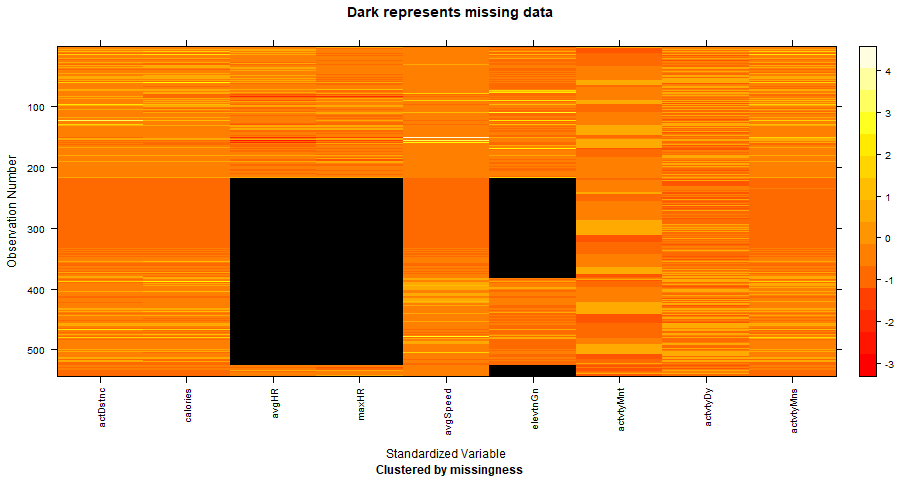

In [6]:
%%R -i activity_tracker_data_continuous -w 900 -h 480 -u px

library(vcd)
library(dplyr)
library(readr)
library(grid) # for gpar
library(RColorBrewer)
library(scales)
library(knitr)
library(mi)

image(missing_data.frame(activity_tracker_data_continuous))

rm(list = ls())

R[write to console]: Loading required package: colorspace

R[write to console]: Registered S3 methods overwritten by 'car':
  method                          from
  influence.merMod                lme4
  cooks.distance.influence.merMod lme4
  dfbeta.influence.merMod         lme4
  dfbetas.influence.merMod        lme4

R[write to console]: VIM is ready to use.


R[write to console]: Suggestions and bug-reports can be submitted at: https://github.com/statistikat/VIM/issues

R[write to console]: 
Attaching package: 'VIM'


R[write to console]: The following object is masked from 'package:datasets':

    sleep


R[write to console]: 
Attaching package: 'mice'


R[write to console]: The following objects are masked from 'package:mi':

    complete, pool


R[write to console]: The following objects are masked from 'package:base':

    cbind, rbind





 Variables sorted by number of missings: 
      Variable Count
         avgHR   307
         maxHR   307
 elevationGain   184
      avgSpeed     1
   actDistance     0
      calories     0
 activityMonth     0
   activityDay     0
  activityMins     0


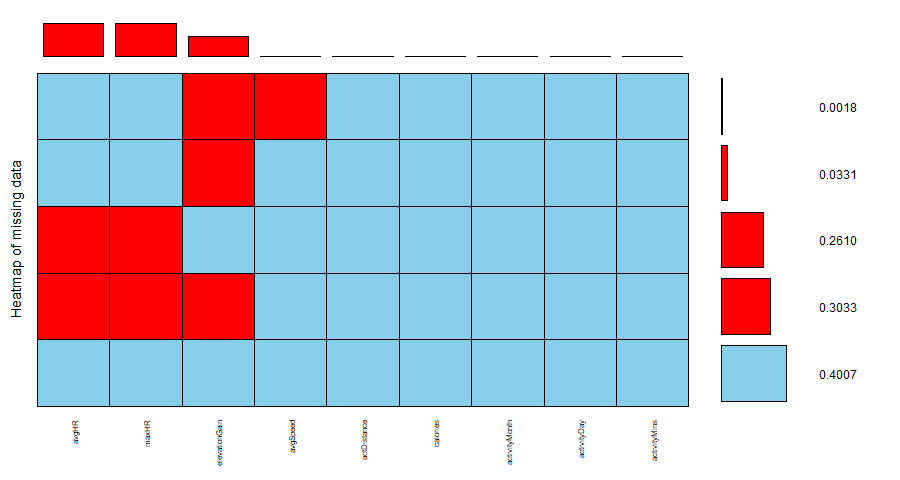

In [7]:
%%R -i activity_tracker_data_continuous -w 900 -h 480 -u px

library(vcd)
library(dplyr)
library(grid) # for gpar
library(RColorBrewer)
library("VIM")
library("mice")
#library(lattice)

aggr_plot <- aggr(activity_tracker_data_continuous, col=c('skyblue','red'), numbers=TRUE, sortVars=TRUE, labels=names(activity_tracker_data_continuous), cex.axis=.7, gap=3, ylab=c("Heatmap of missing data"), combined= TRUE)
rm(list = ls())

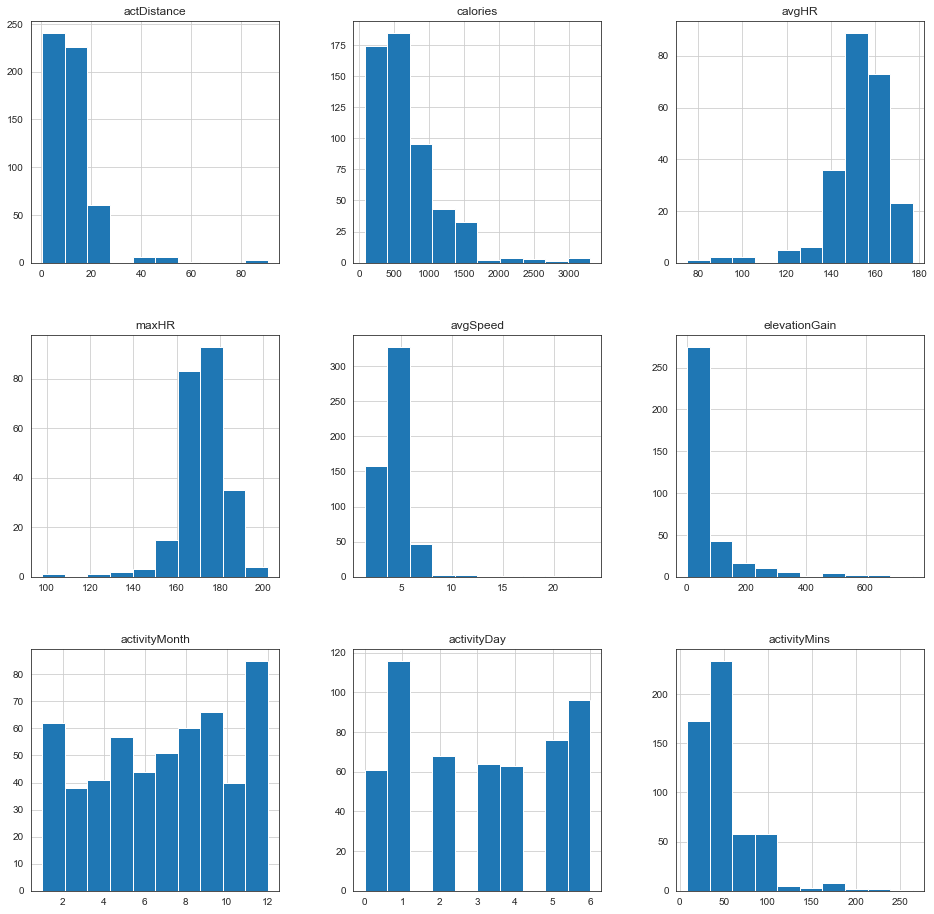

In [8]:
# Daten Histogramm anzeigen
_ = activity_tracker_data.hist(column=continuous_vars, figsize = (16,16))

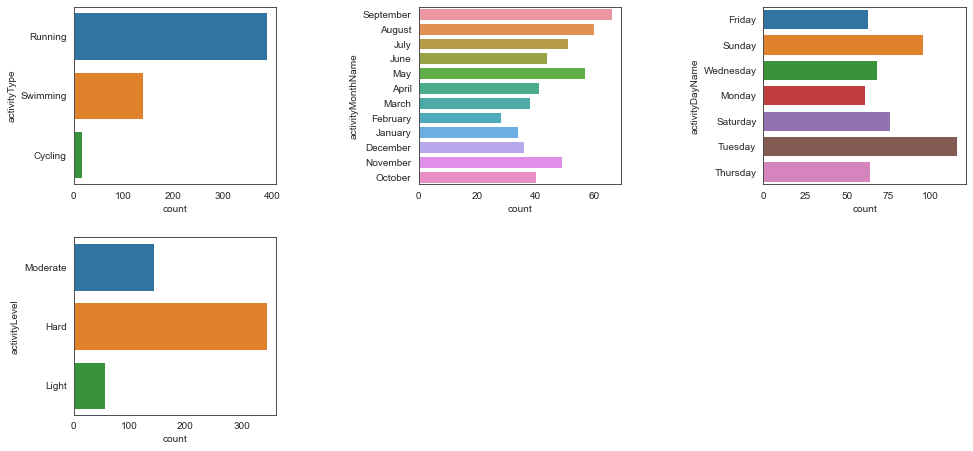

In [9]:
# Histogramm kategorialer Daten

fig, axes = plt.subplots(4, 3, figsize=(16, 16))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.7, hspace=0.3)

for i, ax in enumerate(axes.ravel()):
    if i > 3:
        ax.set_visible(False)
        continue
    sns.countplot(y = categorical_vars[i], data=activity_tracker_data, ax=ax)

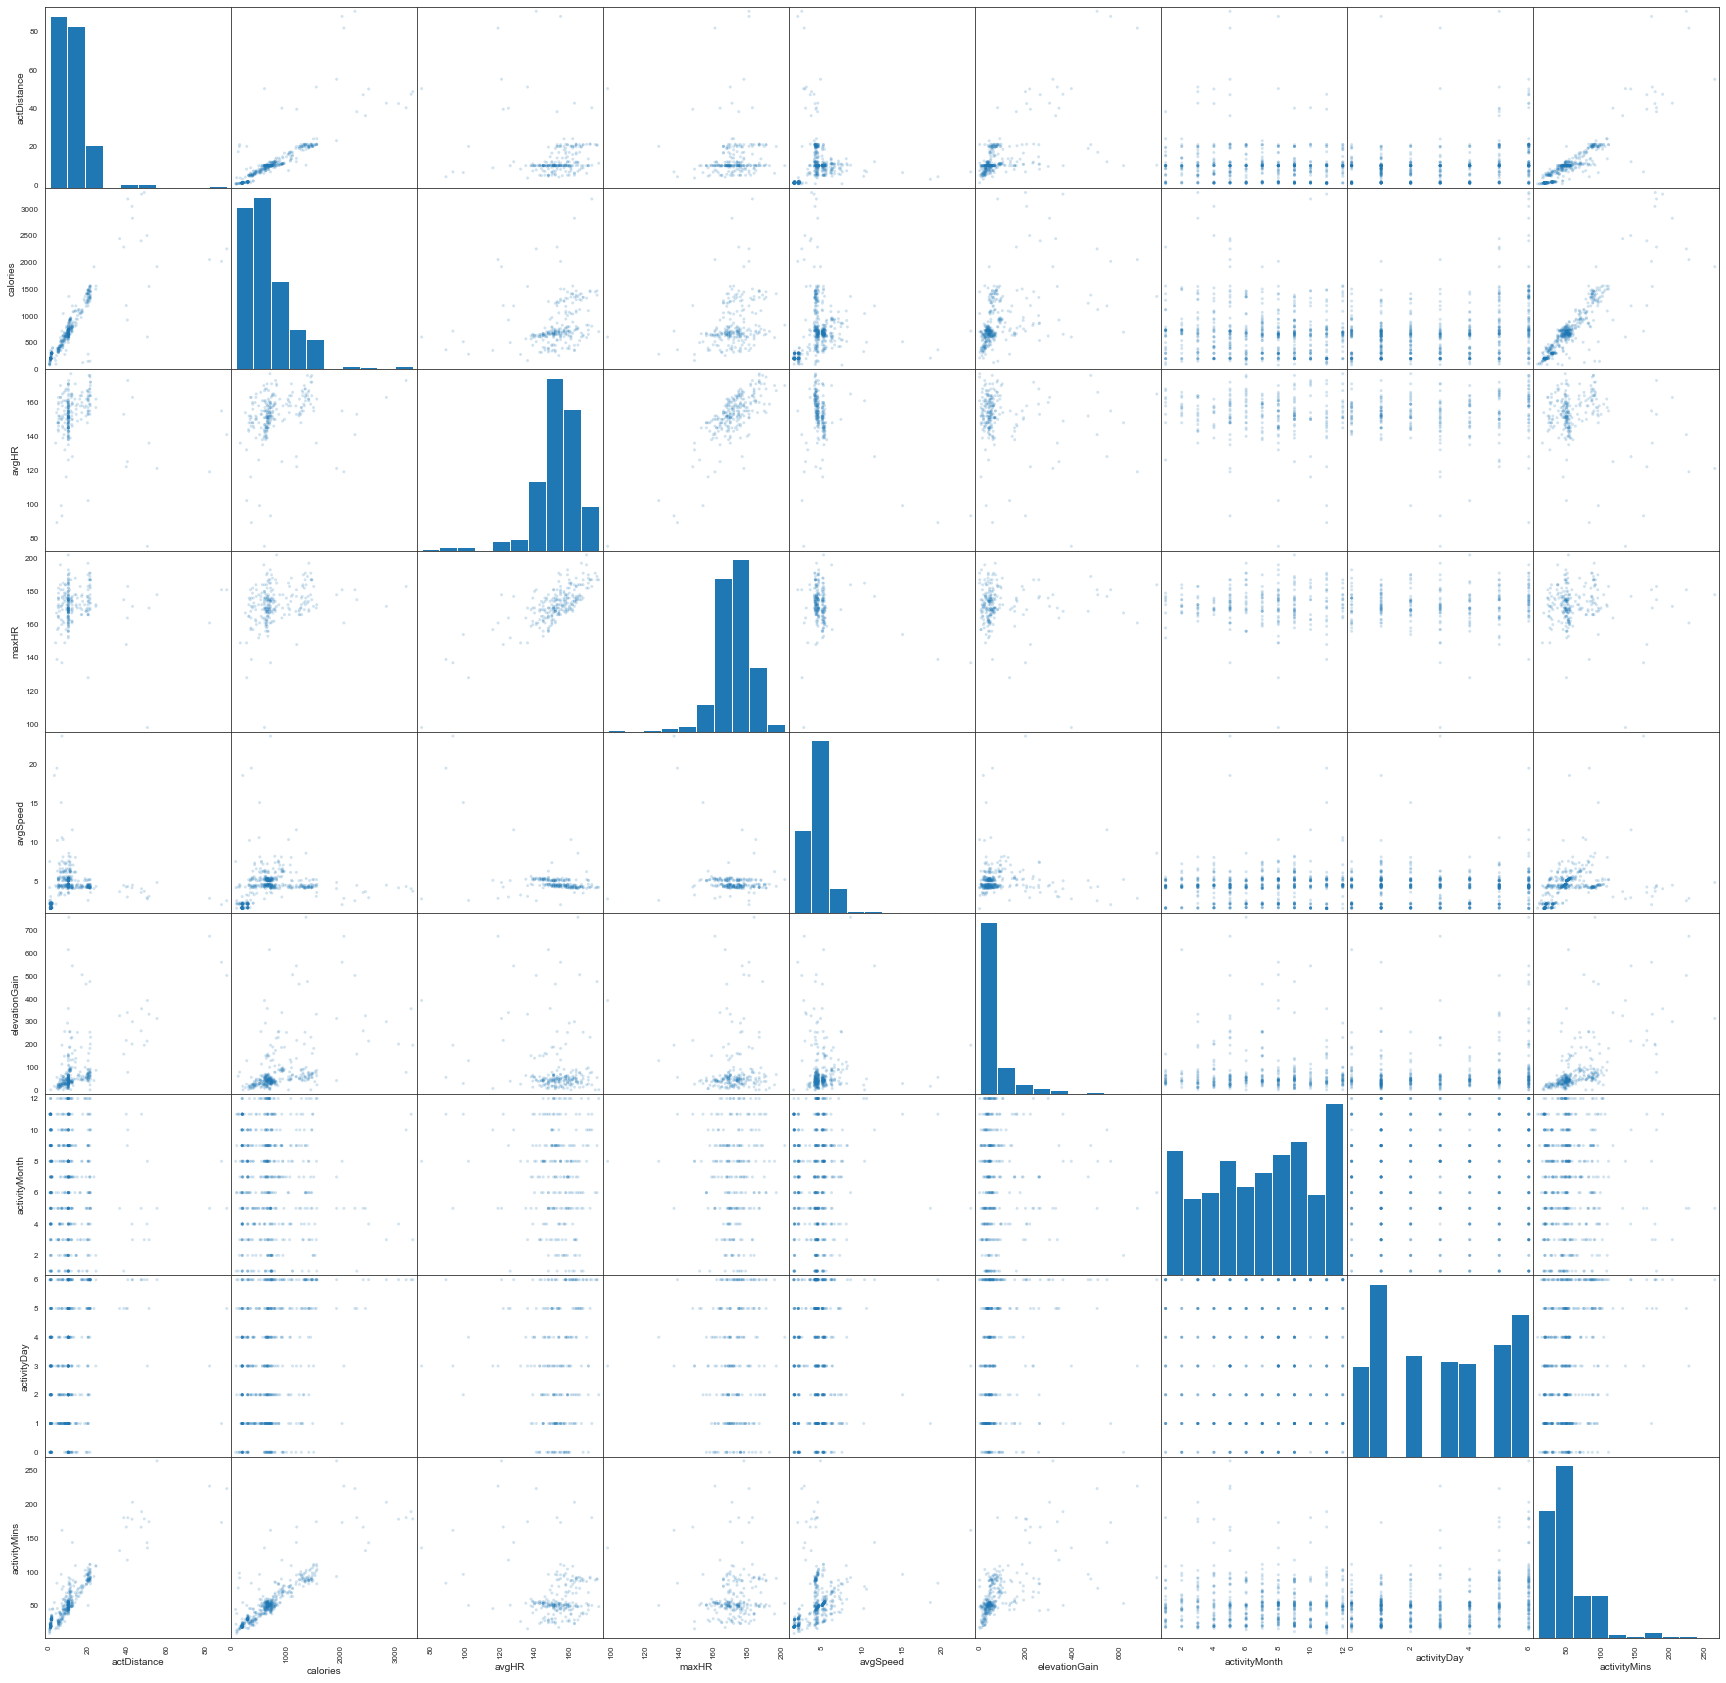

In [10]:
# Multivariate Statistik für kontinuierliche Daten
from pandas.plotting import scatter_matrix
_ = scatter_matrix(activity_tracker_data, alpha=0.2, figsize=(30, 30))

R[write to console]: Loading required package: ggplot2



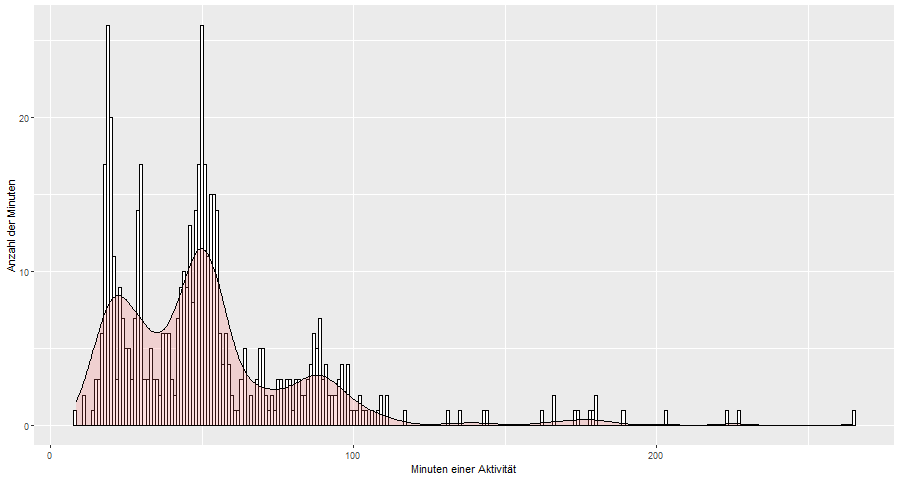

In [11]:
%%R -i activity_tracker_data -w 900 -h 480 -u px

require("ggplot2")

g1 <- ggplot(activity_tracker_data, aes(x=activityMins)) + 
    geom_histogram(aes(y=..count..),      # Histogram with density instead of count on y-axis
                   binwidth=1,
                   colour="black", fill="white") +
    geom_density(aes(y=..count..), alpha=.2, fill="#FF6666") +# Overlay with transparent density plot
    ylab("Anzahl der Minuten") +
    xlab("Minuten einer Aktivität") 
g1

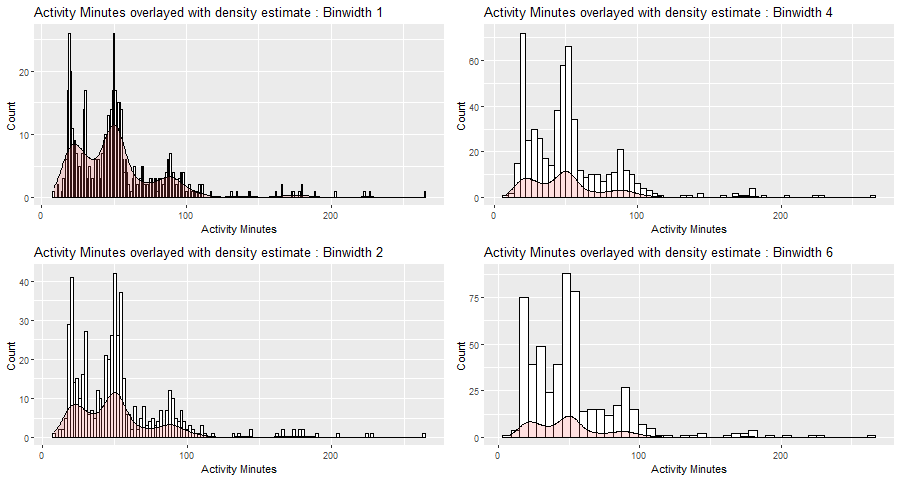

In [12]:
%%R -i activity_tracker_data -w 900 -h 480 -u px

require("ggplot2")

multiplot <- function(..., plotlist=NULL, file, cols=1, layout=NULL) {
  library(grid)

  plots <- c(list(...), plotlist)

  numPlots = length(plots)

  if (is.null(layout)) {
    layout <- matrix(seq(1, cols * ceiling(numPlots/cols)),
                    ncol = cols, nrow = ceiling(numPlots/cols))
  }

 if (numPlots==1) {
    print(plots[[1]])

  } else {
    grid.newpage()
    pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))

    for (i in 1:numPlots) {
      matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))

      print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,
                                      layout.pos.col = matchidx$col))
    }
  }
}
g1 <- ggplot(activity_tracker_data, aes(x=activityMins)) + 
    geom_histogram(aes(y=..count..),      # Histogram with density instead of count on y-axis
                   binwidth=1,
                   colour="black", fill="white") +
    geom_density(aes(y=..count..), alpha=.2, fill="#FF6666") +# Overlay with transparent density plot
    ylab("Count") +
    xlab("Activity Minutes") +
    ggtitle("Activity Minutes overlayed with density estimate : Binwidth 1")

g2 <- ggplot(activity_tracker_data, aes(x=activityMins)) + 
    geom_histogram(aes(y=..count..),      # Histogram with density instead of count on y-axis
                   binwidth=2,
                   colour="black", fill="white") +
    geom_density(aes(y=..count..), alpha=.2, fill="#FF6666") +# Overlay with transparent density plot
    ylab("Count") +
    xlab("Activity Minutes") +
    ggtitle("Activity Minutes overlayed with density estimate : Binwidth 2")

g3 <- ggplot(activity_tracker_data, aes(x=activityMins)) + 
    geom_histogram(aes(y=..count..),      # Histogram with density instead of count on y-axis
                   binwidth=4,
                   colour="black", fill="white") +
    geom_density(aes(y=..count..), alpha=.2, fill="#FF6666") +# Overlay with transparent density plot
    ylab("Count") +
    xlab("Activity Minutes") +
    ggtitle("Activity Minutes overlayed with density estimate : Binwidth 4")

g4 <- ggplot(activity_tracker_data, aes(x=activityMins)) + 
    geom_histogram(aes(y=..count..),      # Histogram with density instead of count on y-axis
                   binwidth=6,
                   colour="black", fill="white") +
    geom_density(aes(y=..count..), alpha=.2, fill="#FF6666") +# Overlay with transparent density plot
    ylab("Count") +
    xlab("Activity Minutes") +
    ggtitle("Activity Minutes overlayed with density estimate : Binwidth 6")

multiplot(g1, g2, g3, g4, cols=2)

# Ausreißer-Analyse

R[write to console]: notch went outside hinges. Try setting notch=FALSE.



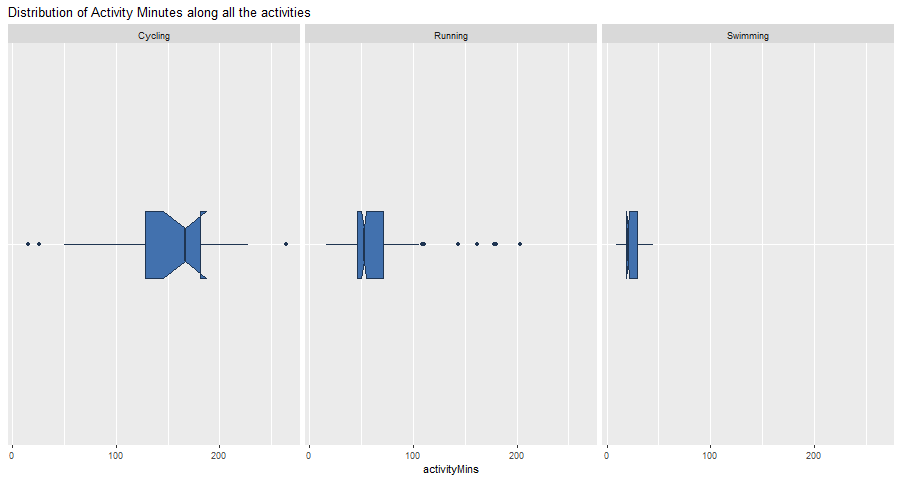

In [13]:
%%R -i activity_tracker_data -w 900 -h 480 -u px

require("ggplot2")

fill <- "#4271AE"
line <- "#1F3552"

ggplot(activity_tracker_data, aes(x=factor(1), y=activityMins)) + geom_boxplot(fill = fill, colour = line, notch = TRUE, width=0.2) +
    guides(fill=FALSE) + coord_flip() + 
    theme(axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank()) +
    ggtitle("Distribution of Activity Minutes along all the activities") + facet_wrap( ~ activityType)

# Wie viele Aktivitäten habe ich zwischen 2013 - 2019 monatlich insgesamt unternommen? 

In [14]:
# Datensatz-Analyse/Abfragen
activity_tracker_data_gMonth = activity_tracker_data.groupby("activityMonthName").count()
activity_tracker_data_gMonth = activity_tracker_data_gMonth[["activityMonth"]]
activity_tracker_data_gMonth.reset_index(inplace=True)
activity_tracker_data_gMonth.rename(columns={'activityMonth':'Count'}, inplace=True)

R[write to console]: Loading required package: viridis

R[write to console]: Loading required package: viridisLite

R[write to console]: 
Attaching package: 'viridis'


R[write to console]: The following object is masked from 'package:scales':

    viridis_pal




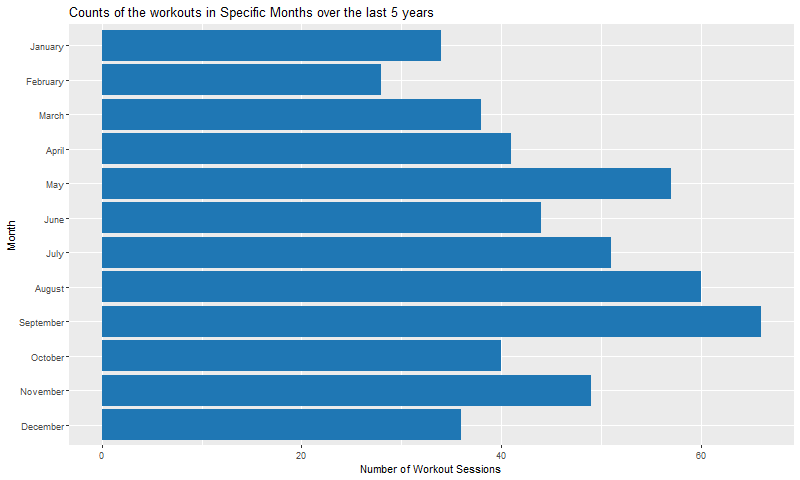

In [15]:
%%R -i activity_tracker_data_gMonth -w 800 -h 480 -u px

require("ggplot2")
require("viridis")

orderedclasses <- c("January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December")
activity_tracker_data_gMonth$activityMonthName <- factor(activity_tracker_data_gMonth$activityMonthName, levels = rev(orderedclasses))

ggplot(activity_tracker_data_gMonth, aes(x = activityMonthName, y = Count)) + 
  geom_col(fill = "#1f77b4") + 
  coord_flip() +
  theme(legend.position="none") +
  xlab("Month") +
  ylab("Number of Workout Sessions") + 
  ggtitle("Counts of the workouts in Specific Months over the last 5 years")

# Wie viele spezifische Aktivitäten habe ich in jedem Monat zwischen 2013 - 2019 durchgeführt?

In [16]:
# Datensatz-Analyse/Abfragen
activity_tracker_data["activityYear"] = activity_tracker_data.startTime.dt.year
activity_tracker_data_gMonth = activity_tracker_data.groupby(["activityYear", "activityMonthName", "activityType"]).count()
activity_tracker_data_gMonth = activity_tracker_data_gMonth[["activityMonth"]]
activity_tracker_data_gMonth.reset_index(inplace=True)
activity_tracker_data_gMonth.rename(columns={'activityMonth':'Count'}, inplace=True)

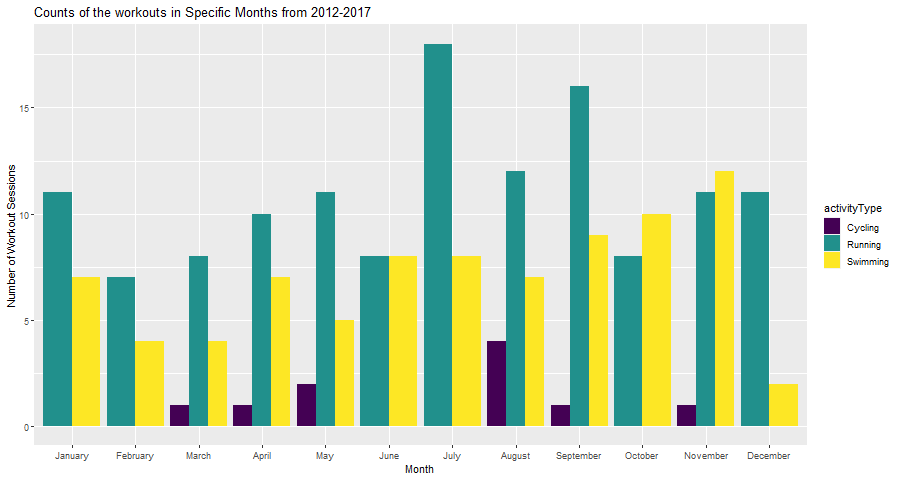

In [17]:
%%R -i activity_tracker_data_gMonth -w 900 -h 480 -u px

require("ggplot2")
require("viridis")

orderedclasses <- c("January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December")
activity_tracker_data_gMonth$activityMonthName <- factor(activity_tracker_data_gMonth$activityMonthName, levels = orderedclasses)

ggplot(activity_tracker_data_gMonth, aes(x = activityMonthName, y = Count, fill = activityType)) + 
  geom_col(position="dodge") + 
  xlab("Month") +
  ylab("Number of Workout Sessions") +
  ggtitle("Counts of the workouts in Specific Months from 2012-2017") + scale_fill_viridis(discrete=TRUE)

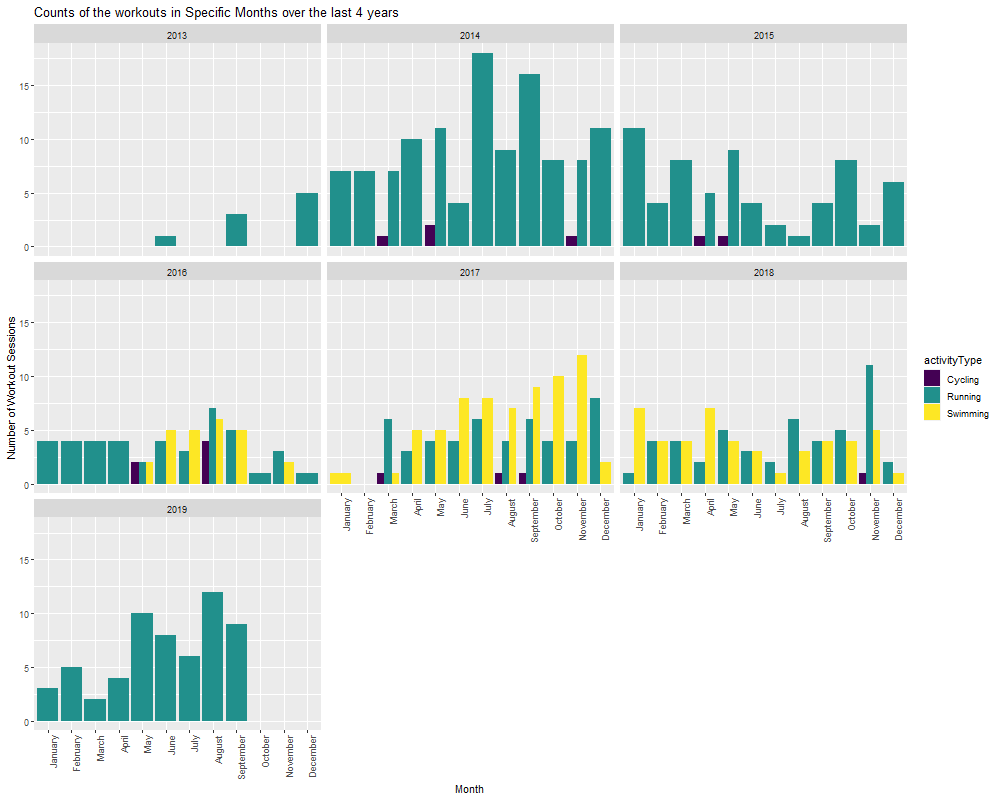

In [18]:
%%R -i activity_tracker_data_gMonth -w 1000 -h 800 -u px

require("ggplot2")
require("viridis")

orderedclasses <- c("January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December")
activity_tracker_data_gMonth$activityMonthName <- factor(activity_tracker_data_gMonth$activityMonthName, levels = orderedclasses)

ggplot(activity_tracker_data_gMonth, aes(x = activityMonthName, y = Count, fill = activityType)) + 
  geom_col(position="dodge") + facet_wrap(~ activityYear) +
  xlab("Month") + 
  ylab("Number of Workout Sessions") +
  ggtitle("Counts of the workouts in Specific Months over the last 4 years") + scale_fill_viridis(discrete=TRUE) +
  theme(axis.text.x = element_text(angle = 90, hjust = 1))

In [19]:
# Day and activity
activity_tracker_data_activDay = activity_tracker_data.groupby(["activityDayName", "activityType"])[['activityDay']].count()
activity_tracker_data_activDay.rename(columns={'activityDay':'Count'}, inplace=True)
activity_tracker_data_activDay.reset_index(inplace=True)
#activity_tracker_data_activDay

R[write to console]: -- Attaching packages --------------------------------------- tidyverse 1.3.0 --

R[write to console]: v tibble  3.0.3     v stringr 1.4.0
v tidyr   1.1.2     v forcats 0.5.0
v purrr   0.3.4     

R[write to console]: -- Conflicts ------------------------------------------ tidyverse_conflicts() --
x scales::col_factor() masks readr::col_factor()
x tidyr::complete()    masks mice::complete(), mi::complete()
x purrr::discard()     masks scales::discard()
x tidyr::expand()      masks Matrix::expand()
x dplyr::filter()      masks stats::filter()
x dplyr::lag()         masks stats::lag()
x tidyr::pack()        masks Matrix::pack()
x tidyr::unpack()      masks Matrix::unpack()

R[write to console]: 
Attaching package: 'gridExtra'


R[write to console]: The following object is masked from 'package:dplyr':

    combine




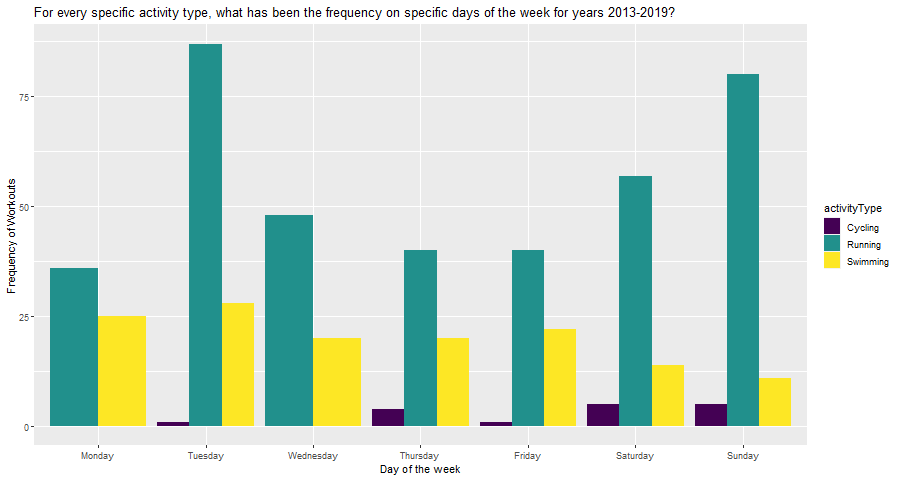

In [20]:
%%R -i activity_tracker_data_activDay -w 900 -h 480 -u px

library(tidyverse)
library(ggplot2)
library(gridExtra)
require("viridis")

orderedclasses <- c("Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday")
activity_tracker_data_activDay$activityDayName <- factor(activity_tracker_data_activDay$activityDayName, levels = orderedclasses)


g1 <- ggplot(activity_tracker_data_activDay, aes(x = activityDayName, y = Count, fill=activityType)) +
  geom_col(position = "dodge") +  scale_fill_viridis(discrete=TRUE) + 
  xlab("Day of the week") +
  ylab("Frequency of Workouts") +
  ggtitle("For every specific activity type, what has been the frequency on specific days of the week for years 2013-2019?")
g1

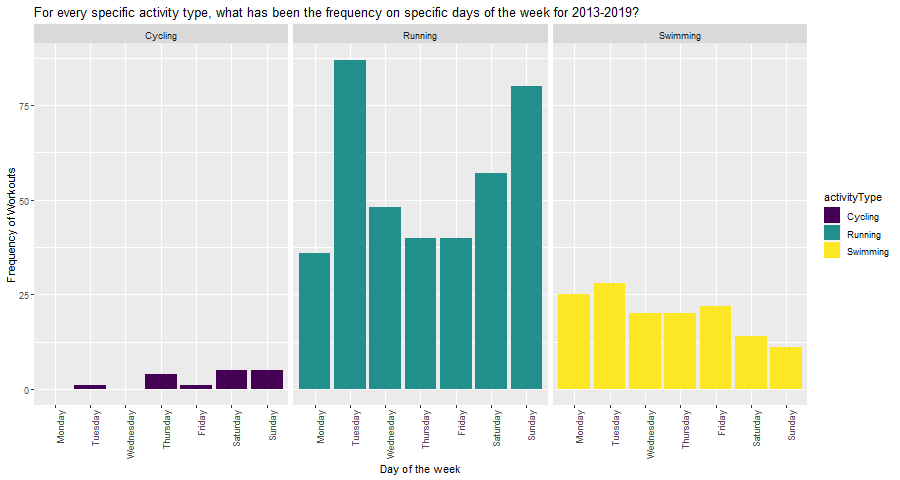

In [21]:
%%R -i activity_tracker_data_activDay -w 900 -h 480 -u px

orderedclasses <- c("Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday")
activity_tracker_data_activDay$activityDayName <- factor(activity_tracker_data_activDay$activityDayName, levels = orderedclasses)

g2 <- ggplot(activity_tracker_data_activDay, aes(x = activityDayName, y = Count, fill=activityType)) +
  geom_col() + facet_wrap(~activityType) + scale_fill_viridis(discrete=TRUE) +
  xlab("Day of the week") +
  ylab("Frequency of Workouts") + theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  ggtitle("For every specific activity type, what has been the frequency on specific days of the week for 2013-2019?")
g2

# Distribution Histogram with overlayed Density Plots and also with varying binwidths

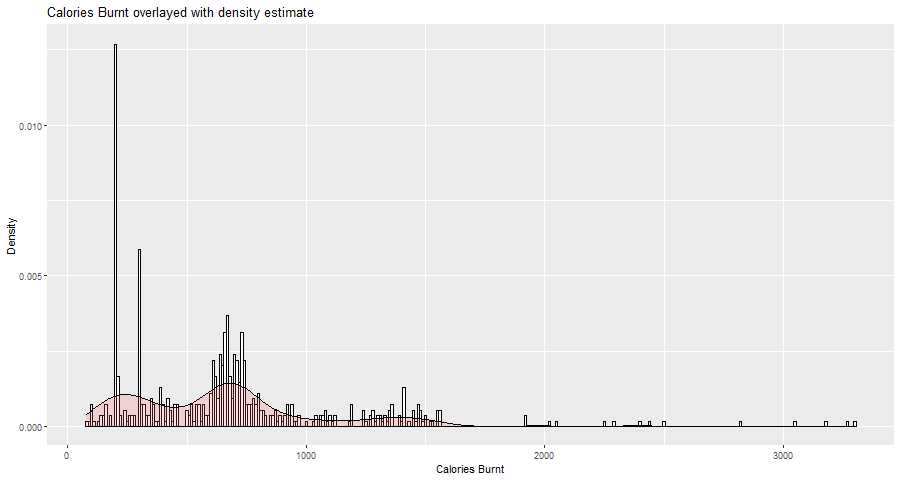

In [22]:
%%R -i activity_tracker_data -w 900 -h 480 -u px

require("ggplot2")

ggplot(activity_tracker_data, aes(x=calories)) + 
    geom_histogram(aes(y=..density..),      # Histogram with density instead of count on y-axis
                   binwidth=10,
                   colour="black", fill="white") +
    geom_density(aes(y=..density..), alpha=.2, fill="#FF6666") +# Overlay with transparent density plot
    ylab("Density") +
    xlab("Calories Burnt") +
    ggtitle("Calories Burnt overlayed with density estimate")

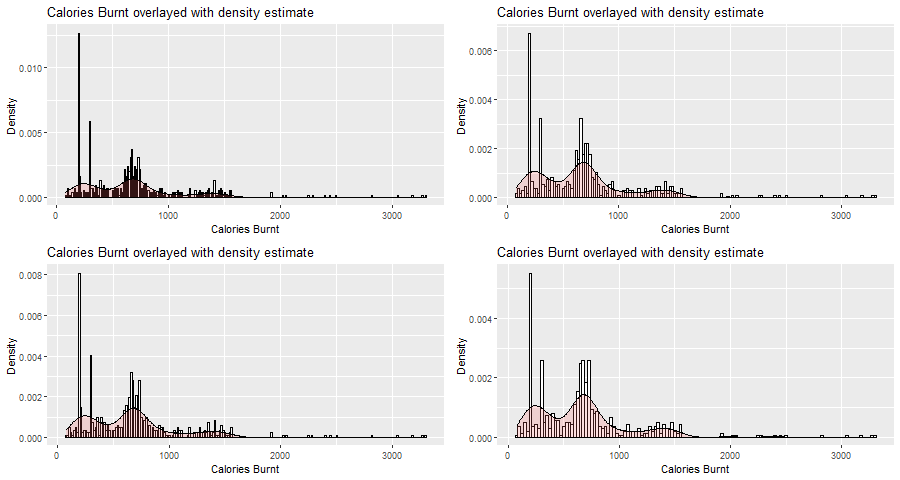

In [23]:
%%R -i activity_tracker_data -w 900 -h 480 -u px

require("ggplot2")

multiplot <- function(..., plotlist=NULL, file, cols=1, layout=NULL) {
  library(grid)

  # Make a list from the ... arguments and plotlist
  plots <- c(list(...), plotlist)

  numPlots = length(plots)

  # If layout is NULL, then use 'cols' to determine layout
  if (is.null(layout)) {
    # Make the panel
    # ncol: Number of columns of plots
    # nrow: Number of rows needed, calculated from # of cols
    layout <- matrix(seq(1, cols * ceiling(numPlots/cols)),
                    ncol = cols, nrow = ceiling(numPlots/cols))
  }

 if (numPlots==1) {
    print(plots[[1]])

  } else {
    # Set up the page
    grid.newpage()
    pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))

    # Make each plot, in the correct location
    for (i in 1:numPlots) {
      # Get the i,j matrix positions of the regions that contain this subplot
      matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))

      print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,
                                      layout.pos.col = matchidx$col))
    }
  }
}

g1 <- ggplot(activity_tracker_data, aes(x=calories)) + 
    geom_histogram(aes(y=..density..),      # Histogram with density instead of count on y-axis
                   binwidth=10,
                   colour="black", fill="white") +
    geom_density(aes(y=..density..), alpha=.2, fill="#FF6666") +# Overlay with transparent density plot
    ylab("Density") +
    xlab("Calories Burnt") +
    ggtitle("Calories Burnt overlayed with density estimate")

g2 <- ggplot(activity_tracker_data, aes(x=calories)) + 
    geom_histogram(aes(y=..density..),      # Histogram with density instead of count on y-axis
                   binwidth=15,
                   colour="black", fill="white") +
    geom_density(aes(y=..density..), alpha=.2, fill="#FF6666") +# Overlay with transparent density plot
    ylab("Density") +
    xlab("Calories Burnt") +
    ggtitle("Calories Burnt overlayed with density estimate")

g3 <- ggplot(activity_tracker_data, aes(x=calories)) + 
    geom_histogram(aes(y=..density..),      # Histogram with density instead of count on y-axis
                   binwidth=20,
                   colour="black", fill="white") +
    geom_density(aes(y=..density..), alpha=.2, fill="#FF6666") +# Overlay with transparent density plot
    ylab("Density") +
    xlab("Calories Burnt") +
    ggtitle("Calories Burnt overlayed with density estimate")

g4 <- ggplot(activity_tracker_data, aes(x=calories)) + 
    geom_histogram(aes(y=..density..),      # Histogram with density instead of count on y-axis
                   binwidth=25,
                   colour="black", fill="white") +
    geom_density(aes(y=..density..), alpha=.2, fill="#FF6666") +# Overlay with transparent density plot
    ylab("Density") +
    xlab("Calories Burnt") +
    ggtitle("Calories Burnt overlayed with density estimate")

multiplot(g1, g2, g3, g4, cols=2)

# Outlier Analysis of Calories Burnt across various Activities

R[write to console]: notch went outside hinges. Try setting notch=FALSE.

R[write to console]: notch went outside hinges. Try setting notch=FALSE.



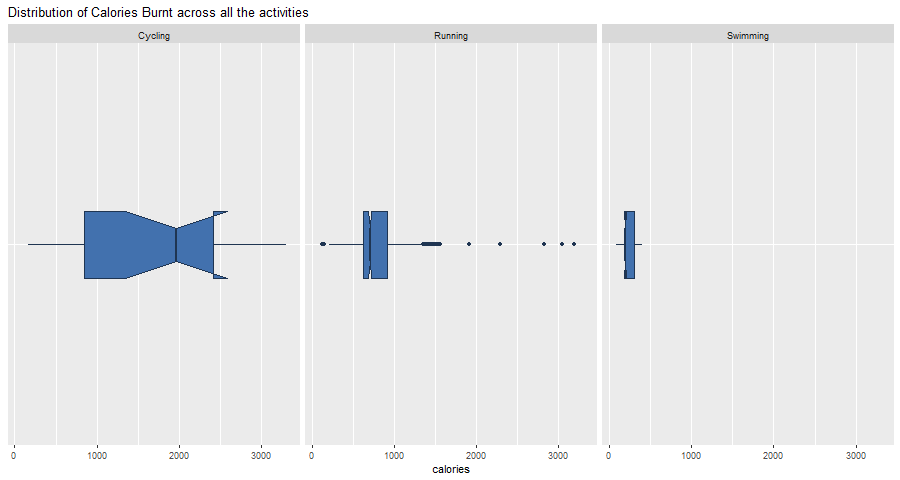

In [24]:
%%R -i activity_tracker_data -w 900 -h 480 -u px

require("ggplot2")

fill <- "#4271AE"
line <- "#1F3552"

ggplot(activity_tracker_data, aes(x=factor(1), y=calories)) + geom_boxplot(fill = fill, colour = line, notch = TRUE, width=0.2) +
    guides(fill=FALSE) + coord_flip() + 
    theme(axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank()) +
    ggtitle("Distribution of Calories Burnt across all the activities") + facet_wrap( ~ activityType)

In [25]:
# year to month activities
year_month_act_mins = activity_tracker_data.groupby(["activityYear", "activityMonthName", "activityType"]).activityMins.agg(["sum"])
year_month_act_mins.reset_index(inplace=True)

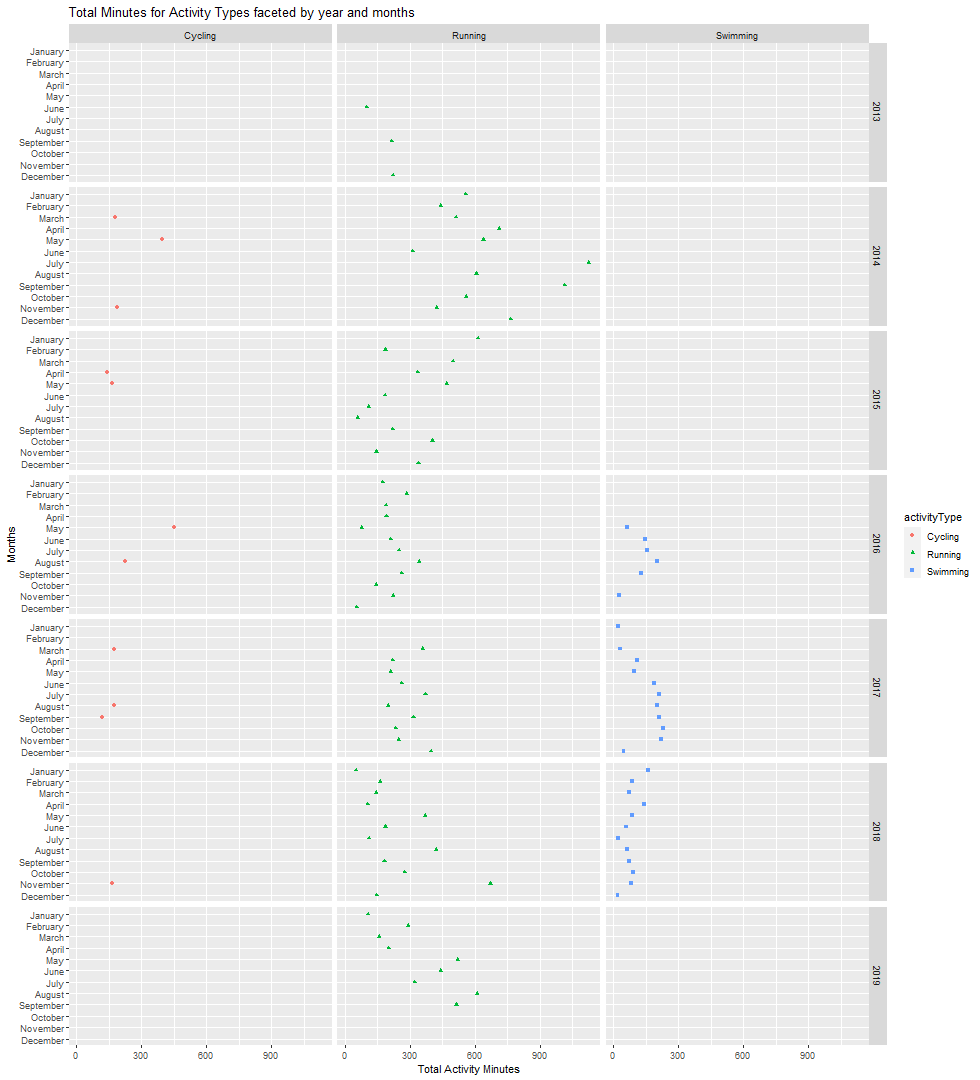

In [26]:
%%R -i year_month_act_mins -w 980 -h 1080 -u px

require("ggplot2")
require("viridis")

orderedclasses <- c("January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December")
year_month_act_mins$activityMonthName <- factor(year_month_act_mins$activityMonthName, levels = rev(orderedclasses))

g1 <- ggplot(year_month_act_mins, aes(x=sum, y=activityMonthName)) + 
    geom_point(aes(color=activityType, shape = activityType)) +
    ylab("Months") + scale_fill_viridis(discrete=TRUE) +
    xlab("Total Activity Minutes") +
    ggtitle("Total Minutes for Activity Types faceted by year and months ") + 
    facet_grid(activityYear ~ activityType)
g1

# Analyse des durchschnittlichen Kalorienverbrauchs für jede Aktivitätsart in den Monaten der Jahre 2013-2019

In [27]:
# year month analytics
year_month_cal_mins = activity_tracker_data.groupby(["activityYear", "activityMonthName", "activityType"]).calories.agg(["mean"])
year_month_cal_mins.reset_index(inplace=True)
#year_month_cal_mins

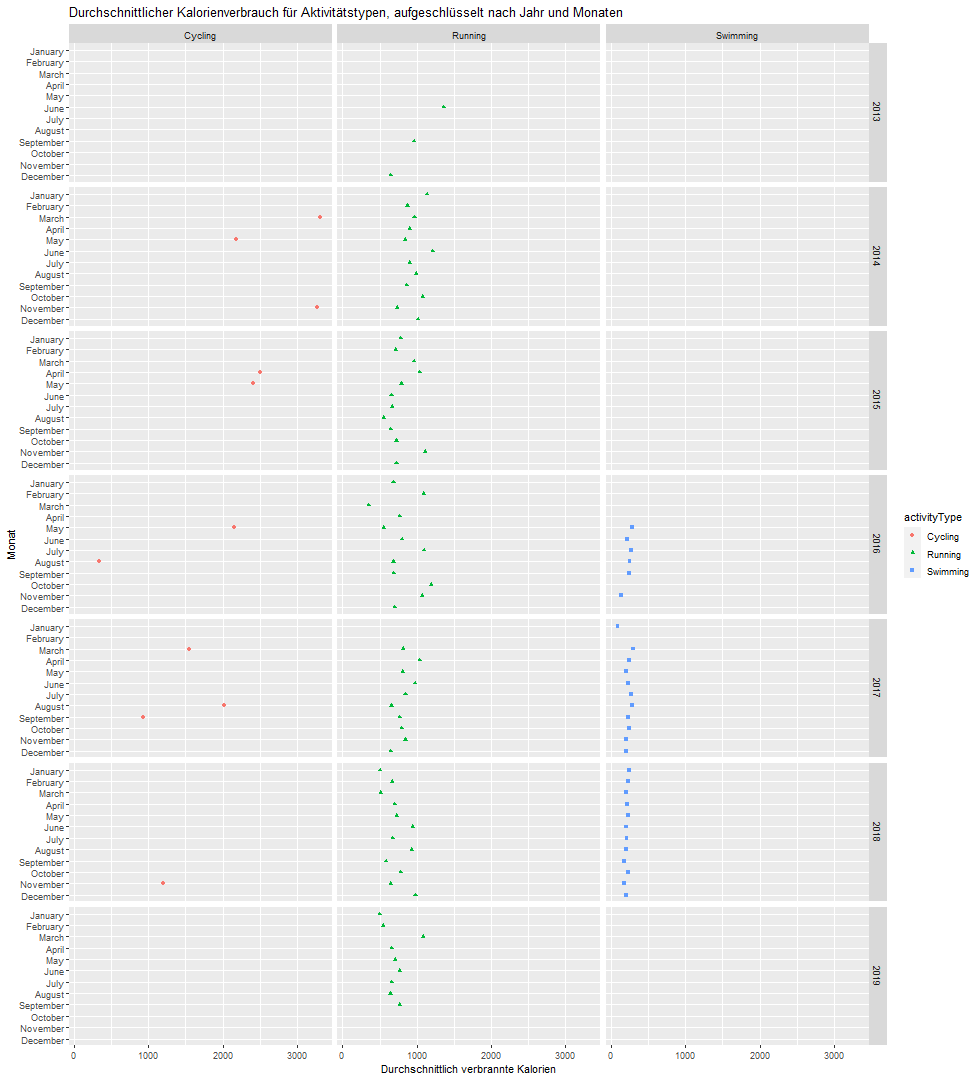

In [28]:
%%R -i year_month_cal_mins -w 980 -h 1080 -u px

require("ggplot2")
require("viridis")

orderedclasses <- c("January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December")
year_month_cal_mins$activityMonthName <- factor(year_month_act_mins$activityMonthName, levels = rev(orderedclasses))

g1 <- ggplot(year_month_cal_mins, aes(x=mean, y=activityMonthName)) + 
    geom_point(aes(color=activityType, shape = activityType)) +
    ylab("Monat") + scale_fill_viridis(discrete=TRUE) +
    xlab("Durchschnittlich verbrannte Kalorien") +
    ggtitle("Durchschnittlicher Kalorienverbrauch für Aktivitätstypen, aufgeschlüsselt nach Jahr und Monaten") + 
    facet_grid(activityYear ~ activityType)
g1

# Wie hat sich mein Aktivitätsniveau (basierend auf der durchschnittlichen Herzfrequenz) entlang der gewählten Aggregationen verändert?

In [29]:
# Activity Levels and their variation along the aggregated days of the week
activity_tracker_data_rec = activity_tracker_data.loc[activity_tracker_data["activityLevel"] != "Not Recorded", :]

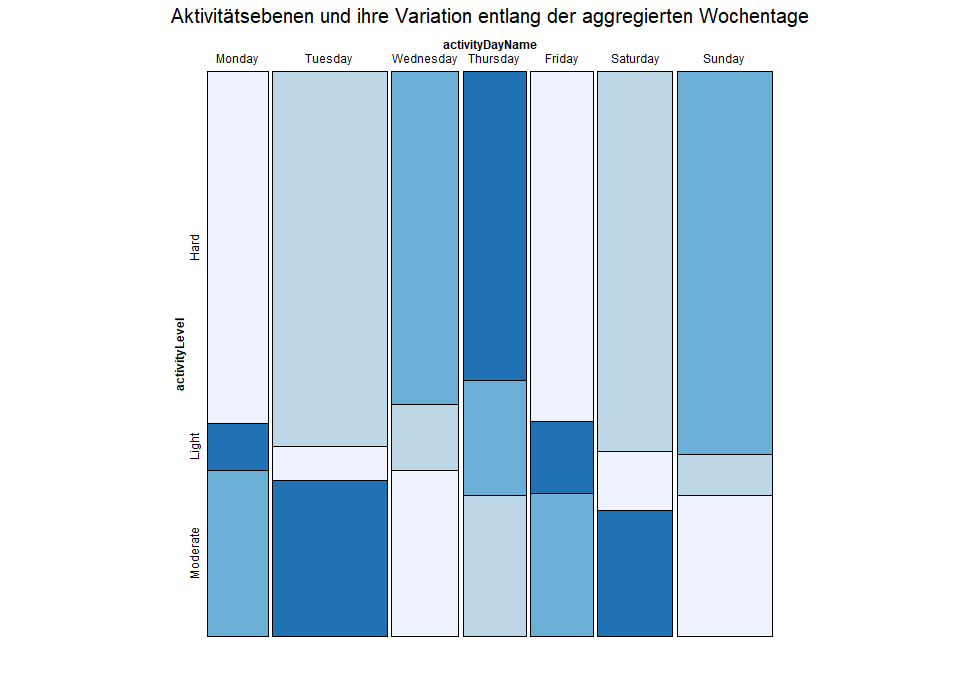

In [30]:
%%R -i activity_tracker_data_rec -w 980 -h 680 -u px


library(vcd)
library(RColorBrewer)

mycolors <- brewer_pal(type = "seq")(4)

orderedclasses <- c("Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday")
activity_tracker_data_rec$activityDayName <- factor(activity_tracker_data_rec$activityDayName, levels = orderedclasses)

vcd::mosaic(activityLevel ~ activityDayName, data = activity_tracker_data_rec, gp = gpar(fill = mycolors), direction = c("v", "h"),
            main = "Aktivitätsebenen und ihre Variation entlang der aggregierten Wochentage")


# Activity Levels and their variation along the aggregated activities

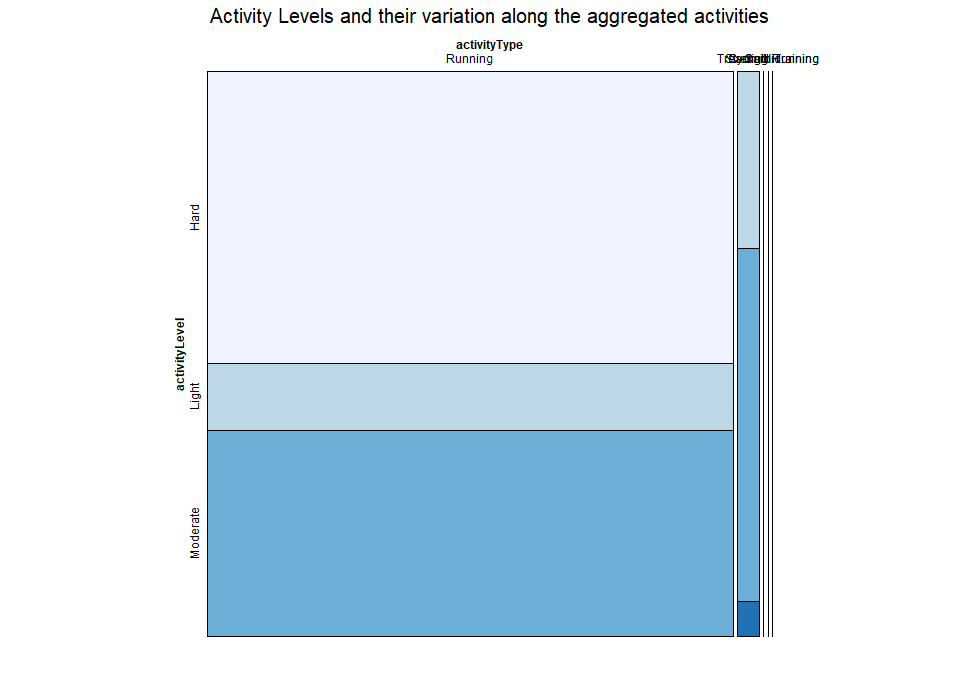

In [31]:
%%R -i activity_tracker_data_rec -w 980 -h 680 -u px


library(vcd)
library(RColorBrewer)

mycolors <- brewer_pal(type = "seq")(4)

orderedclasses <- c("Running", "Cycling", "Cardio", "Treadmill Running", "Strength Training")
activity_tracker_data_rec$activityType <- factor(activity_tracker_data_rec$activityType, levels = orderedclasses)

vcd::mosaic(activityLevel ~ activityType, data = activity_tracker_data_rec, gp = gpar(fill = mycolors), direction = c("v", "h", "v"),
            main = "Activity Levels and their variation along the aggregated activities")



<AxesSubplot:xlabel='activityMins', ylabel='activityLevel'>

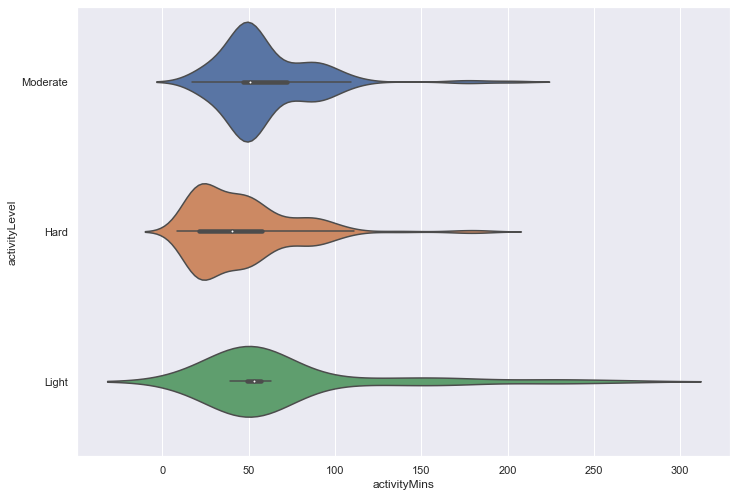

In [32]:
# Wahrscheinlichkeitsanalyse von Aktivitätsdauer und Aktivitätsniveaus
import seaborn.apionly as sns
import numpy as np
import pandas as pd
import seaborn.apionly as sns
import matplotlib.pyplot as plt
import sys
import os,fnmatch
import matplotlib as mpl
import matplotlib.cm as cm
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.violinplot(x=activity_tracker_data.activityMins,y=activity_tracker_data.activityLevel)

<AxesSubplot:xlabel='activityDay', ylabel='activityMins'>

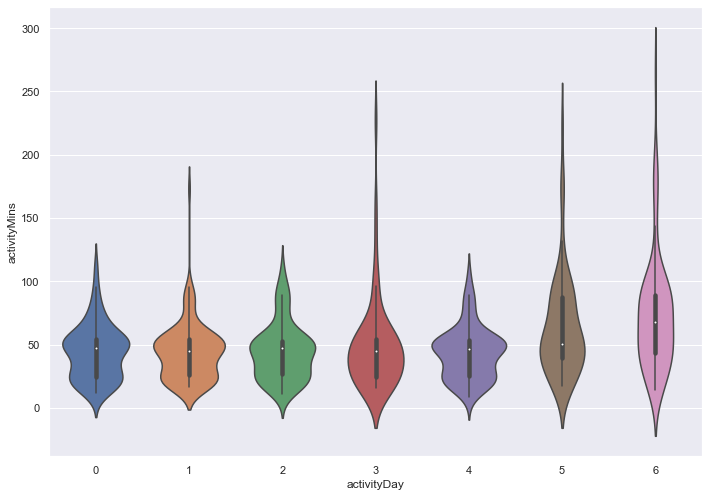

In [33]:
# Wahrscheinlichkeitsanalyse von Aktivitätstag und Aktivitätsdauer
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.violinplot(x=activity_tracker_data.activityDay,y=activity_tracker_data.activityMins)

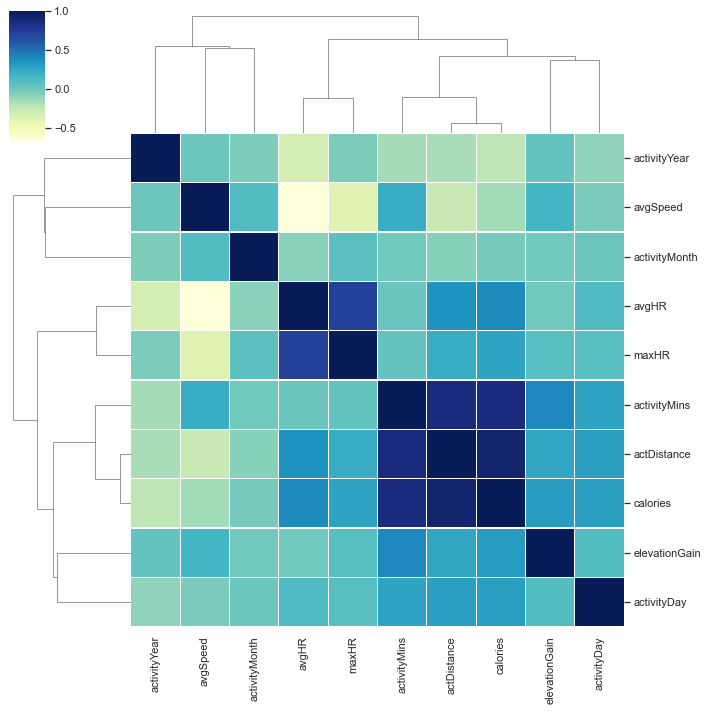

In [34]:
# Korrelationsanalyse
corr_analysis_data = activity_tracker_data.loc[activity_tracker_data['activityType']=='Running']
corrmat = corr_analysis_data.corr() 
cg = sns.clustermap(corrmat, cmap ="YlGnBu", linewidths = 0.1); 
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation = 0) 
cg 

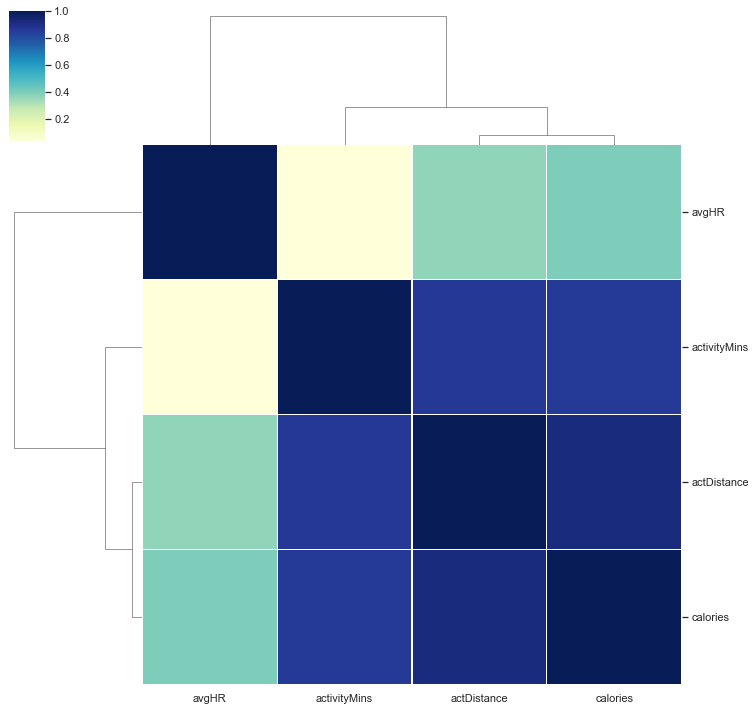

In [35]:
# nur laufende Aktivität und eine begrenzte Korrelationsanalyse für einige Variablen auswählen
corr_analysis_data = activity_tracker_data.loc[activity_tracker_data['activityType']=='Running']
corr_analysis_data = corr_analysis_data[['actDistance','calories','avgHR','activityMins','activityLevel']]
corrmat = corr_analysis_data.corr() 
cg = sns.clustermap(corrmat, cmap ="YlGnBu", linewidths = 0.1); 
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation = 0) 
cg 

# Klassifizierung der Intensitätsstufe

In [36]:
# den Klassifikator vorbereiten
import numpy
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, BoundaryNorm
from sklearn import neighbors
import matplotlib.patches as mpatches
import graphviz
from sklearn.tree import export_graphviz
import matplotlib.patches as mpatches

import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split


In [37]:
# Visualizierung
def plot_feature_importances(clf, feature_names):
    c_features = len(feature_names)
    plt.barh(range(c_features), clf.feature_importances_)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature name")
    plt.yticks(numpy.arange(c_features), feature_names)

def plot_labelled_scatter(X, y, class_labels):
    num_labels = len(class_labels)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    marker_array = ['o', '^', '*']
    color_array = ['#FFFF00', '#00AAFF', '#000000', '#FF00AA']
    cmap_bold = ListedColormap(color_array)
    bnorm = BoundaryNorm(numpy.arange(0, num_labels + 1, 1), ncolors=num_labels)
    fig = plt.figure()

    plt.scatter(X[:, 0], X[:, 1], s=65, c=y, cmap=cmap_bold, norm = bnorm, alpha = 0.40, edgecolor='black', lw = 1)

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    h = []
    for c in range(0, num_labels):
        h.append(mpatches.Patch(color=color_array[c], label=class_labels[c]))
    plt.legend(handles=h)

    plt.show()


def plot_class_regions_for_classifier_subplot(clf, X, y, X_test, y_test, title, subplot, target_names = None, plot_decision_regions = True):

    numClasses = numpy.amax(y) + 1
    color_list_light = ['#FFFFAA', '#EFEFEF', '#AAFFAA', '#AAAAFF']
    color_list_bold = ['#EEEE00', '#000000', '#00CC00', '#0000CC']
    cmap_light = ListedColormap(color_list_light[0:numClasses])
    cmap_bold  = ListedColormap(color_list_bold[0:numClasses])

    h = 0.03
    k = 0.5
    x_plot_adjust = 0.1
    y_plot_adjust = 0.1
    plot_symbol_size = 50

    x_min = X[:, 0].min()
    x_max = X[:, 0].max()
    y_min = X[:, 1].min()
    y_max = X[:, 1].max()
    x2, y2 = numpy.meshgrid(numpy.arange(x_min-k, x_max+k, h), numpy.arange(y_min-k, y_max+k, h))

    P = clf.predict(numpy.c_[x2.ravel(), y2.ravel()])
    P = P.reshape(x2.shape)

    if plot_decision_regions:
        subplot.contourf(x2, y2, P, cmap=cmap_light, alpha = 0.8)

    subplot.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, s=plot_symbol_size, edgecolor = 'black')
    subplot.set_xlim(x_min - x_plot_adjust, x_max + x_plot_adjust)
    subplot.set_ylim(y_min - y_plot_adjust, y_max + y_plot_adjust)

    if (X_test is not None):
        subplot.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cmap_bold, s=plot_symbol_size, marker='^', edgecolor = 'black')
        train_score = clf.score(X, y)
        test_score  = clf.score(X_test, y_test)
        title = title + "\nTrain score = {:.2f}, Test score = {:.2f}".format(train_score, test_score)

    subplot.set_title(title)

    if (target_names is not None):
        legend_handles = []
        for i in range(0, len(target_names)):
            patch = mpatches.Patch(color=color_list_bold[i], label=target_names[i])
            legend_handles.append(patch)
        subplot.legend(loc=0, handles=legend_handles)


def plot_class_regions_for_classifier(clf, X, y, X_test=None, y_test=None, title=None, target_names = None, plot_decision_regions = True):

    numClasses = numpy.amax(y) + 1
    color_list_light = ['#FFFFAA', '#EFEFEF', '#AAFFAA', '#AAAAFF']
    color_list_bold = ['#EEEE00', '#000000', '#00CC00', '#0000CC']
    cmap_light = ListedColormap(color_list_light[0:numClasses])
    cmap_bold  = ListedColormap(color_list_bold[0:numClasses])

    h = 0.03
    k = 0.5
    x_plot_adjust = 0.1
    y_plot_adjust = 0.1
    plot_symbol_size = 50

    x_min = X[:, 0].min()
    x_max = X[:, 0].max()
    y_min = X[:, 1].min()
    y_max = X[:, 1].max()
    x2, y2 = numpy.meshgrid(numpy.arange(x_min-k, x_max+k, h), numpy.arange(y_min-k, y_max+k, h))

    P = clf.predict(numpy.c_[x2.ravel(), y2.ravel()])
    P = P.reshape(x2.shape)
    fig=plt.figure(dpi=100)
    if plot_decision_regions:
        plt.contourf(x2, y2, P, cmap=cmap_light, alpha = 0.8)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, s=plot_symbol_size, edgecolor = 'black')
    plt.xlim(x_min - x_plot_adjust, x_max + x_plot_adjust)
    plt.ylim(y_min - y_plot_adjust, y_max + y_plot_adjust)

    if (X_test is not None):
        plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cmap_bold, s=plot_symbol_size, marker='^', edgecolor = 'black')
        train_score = clf.score(X, y)
        test_score  = clf.score(X_test, y_test)
        title = title + "\nTrain score = {:.2f}, Test score = {:.2f}".format(train_score, test_score)

    if (target_names is not None):
        legend_handles = []
        for i in range(0, len(target_names)):
            patch = mpatches.Patch(color=color_list_bold[i], label=target_names[i])
            legend_handles.append(patch)
        plt.legend(loc=0, handles=legend_handles)

    if (title is not None):
        plt.title(title)
    plt.show()
    #fig.savefig("RBF.svg", format="svg")

In [38]:
# Training- und Testdatenaufbereitung
X = corr_analysis_data[['actDistance','calories','avgHR','activityMins']]
y = corr_analysis_data[['activityLevel']]
# handle nans in a reasonable way
X['calories'].fillna(X['calories'].mean(), inplace=True)
X['avgHR'].fillna(X['avgHR'].median(), inplace=True)
X['calories'] = X['calories'] + np.random.randint(50, 150, *X['calories'].shape)
X['avgHR'] = X['avgHR'] + np.random.randint(1, 15, *X['avgHR'].shape)

# extract the most relevant features
# perform a Xisquared test to the samples to retrieve only the two best features 
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X_new = SelectKBest(chi2, k=2).fit_transform(X, y)
#based on the most relevant features prepare data for classification
rel_feat1 = X.columns[(X == X_new[0][0]).any()][0]
rel_feat2 = X.columns[(X == X_new[0][1]).any()][0]
# extract those columns with the most relevant features
X = X[[X.columns[(X == X_new[0][0]).any()][0], X.columns[(X == X_new[0][1]).any()][0]]]

In [39]:
# SVM-Klassifikator
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

# LinearSVC with M classes generates M one vs rest classifiers.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 10)
clf = OneVsRestClassifier(SVC(kernel='linear', probability=True, class_weight='balanced'))
clf.fit(X_train, y_train)
proba = clf.predict_proba(X_train)
y_pred = clf.predict(X_test)

# we have 4 predictor variables and one label
from sklearn.preprocessing import LabelEncoder

# creating instance of labelencoder
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
label_vals = labelencoder.fit_transform(y['activityLevel'])

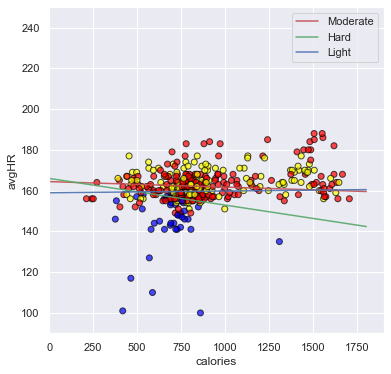

In [40]:
# Visualizierung
from matplotlib.colors import ListedColormap


plt.figure(figsize=(6,6))
colors = ['r', 'g', 'b', 'y']
cmap_activities = ListedColormap(['#FF0000', '#00FF00', '#0000FF','#FFFF00'])

plt.scatter(X[['calories']], X[['avgHR']],
           c=label_vals, cmap=cmap_activities, edgecolor = 'black', alpha=.7)

x_0_range = np.linspace(0, 1800)

for w, b, color in zip(clf.coef_, clf.intercept_, ['r', 'g', 'b', 'y']):
    plt.plot(x_0_range, -(x_0_range * w[0] + b) / w[1], c=color, alpha=.9)
    
plt.legend(y['activityLevel'].unique())
plt.xlabel('calories')
plt.ylabel('avgHR')
plt.xlim(0, 1900)
plt.ylim(90, 250)
plt.show()

              precision    recall  f1-score   support

    Moderate       1.00      0.04      0.08        51
        Hard       0.50      0.93      0.65        15
       Light       0.42      0.90      0.57        31

    accuracy                           0.45        97
   macro avg       0.64      0.63      0.43        97
weighted avg       0.74      0.45      0.32        97



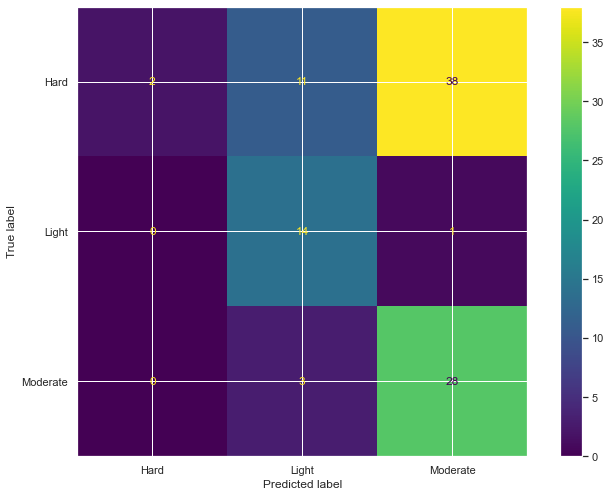

In [41]:
# Genauigkeitsanalyse
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=y['activityLevel'].unique()))

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
confusion_matrix(y_test, y_pred)
plot_confusion_matrix(clf, X_test, y_test)

### Ein linearer Klassifikator kann nicht die drei Aktivitätsebenen trennen. Als Hausaufgabe versuchen Sie bitte andere Typen von Klassifikatoren !

# Klassifizierung der Aktivität 

In [42]:
# den Klassifikator vorbereiten
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

In [43]:
# Training- und Testdatenaufbereitung
corr_analysis_data = activity_tracker_data[['activityType','calories','avgHR']]
X = corr_analysis_data[['calories','avgHR']]
y = corr_analysis_data[['activityType']]
# handle nans in a reasonable way
X['calories'].fillna(X['calories'].mean(), inplace=True)
X['avgHR'].fillna(X['avgHR'].median(), inplace=True)
X['calories'] = X['calories'] + np.random.randint(50, 150, *X['calories'].shape)
X['avgHR'] = X['avgHR'] + np.random.randint(5, 15, *X['avgHR'].shape)

In [44]:
# Mehrklassen-Klassifikator
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

# LinearSVC with M classes generates M one vs rest classifiers.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 10)
clf = OneVsRestClassifier(SVC(kernel='linear', probability=True, class_weight='balanced'))
clf.fit(X_train, y_train)
proba = clf.predict_proba(X_train)
y_pred = clf.predict(X_test)

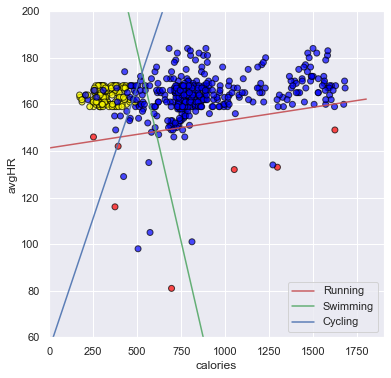

In [45]:
# Visualizierung
# we have 4 predictor variables and one label
from sklearn.preprocessing import LabelEncoder

# creating instance of labelencoder
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
label_vals = labelencoder.fit_transform(y['activityType'])

from matplotlib.colors import ListedColormap


plt.figure(figsize=(6,6))
colors = ['r', 'g', 'b', 'y']
cmap_activities = ListedColormap(['#FF0000', '#00FF00', '#0000FF','#FFFF00'])

plt.scatter(X[['calories']], X[['avgHR']],
           c=label_vals, cmap=cmap_activities, edgecolor = 'black', alpha=.7)

x_0_range = np.linspace(0, 1800)

for w, b, color in zip(clf.coef_, clf.intercept_, ['r', 'g', 'b', 'y']):
    plt.plot(x_0_range, -(x_0_range * w[0] + b) / w[1], c=color, alpha=.9)
    
plt.legend(y['activityType'].unique())
plt.xlabel('calories')
plt.ylabel('avgHR')
plt.xlim(0, 1900)
plt.ylim(60, 200)
plt.show()

              precision    recall  f1-score   support

     Running       0.33      0.20      0.25         5
    Swimming       0.97      0.91      0.94        93
     Cycling       0.84      1.00      0.92        38

    accuracy                           0.91       136
   macro avg       0.71      0.70      0.70       136
weighted avg       0.91      0.91      0.91       136



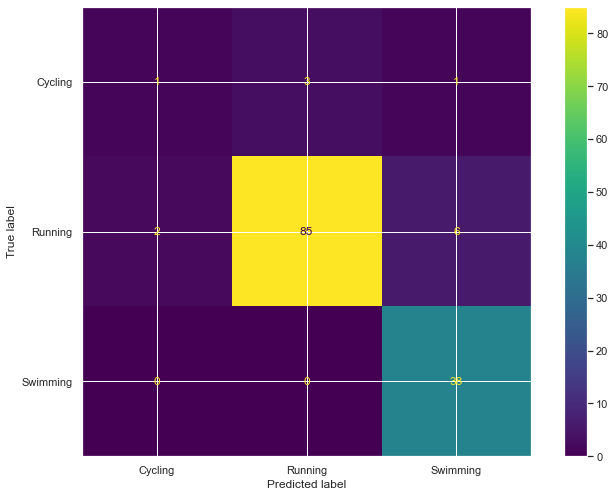

In [46]:
# Genauigkeitsanalyse
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=y['activityType'].unique()))

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
confusion_matrix(y_test, y_pred)
plot_confusion_matrix(clf, X_test, y_test)